In [2]:
import pandas as pd
import itertools
import numpy as np
import random
import matplotlib.pyplot as plt
import time

In [3]:
df = pd.read_csv('dataset.csv')
m = df.shape[0]
df.head()

,ORs,Weekday,Week Number,Block,Beds,Surgeon ID,Service ID
0,1,1,1,"(d1,o1)",5,13,0
1,1,1,2,"(d1,o1)",6,42,2
2,1,1,3,"(d1,o1)",6,98,4
3,1,1,4,"(d1,o1)",7,12,0
4,1,2,1,"(d2,o1)",7,46,2


In [31]:
def makeBlockStr(day, room):
    return f"(d{day},o{room})"

makeBlockStr(1, 3)

'(d1,o3)'

In [75]:
def getRoom(b):
    room = b.split('o')[1][0:-1]
    return int(room)

getRoom('(d2,o43)')

43

In [33]:
# Define days and operating rooms
days = [f'd{i}' for i in range(1, 8)]
rooms = [f'o{i}' for i in range(1, 53)]

# Generate all valid block pairs P
P = []
for (d1, o1), (d2, o2) in itertools.product(itertools.product(days, rooms), repeat=2):
    room_num1, room_num2 = int(o1[1:]), int(o2[1:])  # Extract room numbers
    if abs(room_num1 - room_num2) <= 10:
        new_item = (f"({d1},{o1})", f"({d2},{o2})")
        if not new_item in P:
            P.append(new_item)

# Print a sample of P to check


In [34]:
from collections import Counter

def find_duplicates(lst):
    counts = Counter(lst)
    return [item for item, count in counts.items() if count > 1]

lst = [1, 2, 3, 4, 2, 3, 5, 3]
print(find_duplicates(P))  # Output: [2, 3]


[]


In [35]:
def getDay(b):
    day = b.split('d')[1][0]
    return int(day)

In [36]:
def cases(b):
    line = df[(df['Block'] == b)]
    return list(line['Beds'])

In [37]:
def alloc(b, v):
    line = df[(df['Block'] == b) & (df['Service ID'] == v)]
    return len(line)

In [38]:
# def Di(b, w, s):
#     line = df[(df['Block'] == b) & (df['Week Number'] == w)]
#     return line['Surgeon ID'] == s

In [39]:
def Di(b, w, s):
    line = df[(df['Block'] == b) & (df['Week Number'] == w) & (df['Surgeon ID'] == s)]
    return not line.empty  # Returns True if at least one row exists


In [40]:
Di('(d1,o1)',2,42)

True

In [41]:
totalBedCount = sum(df['Beds'].to_numpy())

In [42]:
p = P[0]
def getBs(p):
    b1, b2 = p
    return [b1, b2]

getBs(p)[0]

'(d1,o1)'

In [89]:
B = df['Block'].unique()
P_set = set()

for b1, b2 in itertools.product(B, repeat=2):
    o1 = getRoom(b1)
    o2 = getRoom(b2)
    if abs(o1 - o2) <= 10:
        P_set.add((b1,b2))

P = list(P_set)
len(P)

48118

In [97]:
import gurobipy as gp
from gurobipy import GRB

# Define sets
print("-"*10, "Reading sets from df and precompute", "-"*10)
start = time.time()

W = df['Weekday'].unique()            #weekday
N = df['Week Number'].unique()        #OR
O = df['ORs'].unique()                #OR
B = df['Block'].unique()              #Block
S = df['Surgeon ID'].unique()         #Surgeon
V = df['Service ID'].unique()         #Service
totalBedCount = sum(df['Beds'].to_numpy())

l_v = [0,0,0,0,0]                     # lower bound for each service
u_v = [150,150,150,150,150]           # upper bound for each service



F = ['1']
peak = 338


# Variables defined here is some precompute values, this is used to reduce complexity of constraints
Di_dict = {(b, w, s): not df[(df['Block'] == b) & (df['Week Number'] == w) & (df['Surgeon ID'] == s)].empty
           for b in B for w in N for s in S}



print(f"Finish, uses {time.time() - start:.5f} seconds")
# Create a new model
print("-"*10, "Creating model object", "-"*10)
start = time.time()

model = gp.Model("OR opt")


print(f"Finish, uses {time.time() - start:.5f} seconds")
# Define decision variables
print("-"*10, "Setting decision variables", "-"*10)
start = time.time()

x_p = model.addVars(P, vtype=GRB.BINARY, name="x_p")  # Allowed Moves
z = model.addVars(F, vtype=GRB.INTEGER, name="z")

summed_values = model.addVars(W, N, vtype=GRB.INTEGER, name="sum_var") # Total bed counts for weekday d in week i



print(f"Finish, uses {time.time() - start:.5f} seconds")
# Define constraint
print("-"*10, "Setting constraints", "-"*10)

# Additional (not from original paper)

print("Setting additional constraints")
start = time.time()

for b1 in B:  # This constraint makes sure that each block can only move to one place
    model.addConstr(gp.quicksum(x_p[p] for p in P if b1 == getBs(p)[0]) == 1)

# model.addConstr(gp.quicksum(summed_values[d, i] for d in W for i in N) == totalBedCount)


print(f"Finish, uses {time.time() - start:.5f} seconds")
# (2)

print("Setting constraints (2)")
start = time.time()

for b2 in B:
    model.addConstr(gp.quicksum(x_p[p] for p in P if b2 == getBs(p)[1]) == 1)


print(f"Finish, uses {time.time() - start:.5f} seconds")
# (3)

print("Setting constraints (3)")
start = time.time()

for f in F:
    for d in W: # Weekday
        for i in N:
            model.addConstr(gp.quicksum(cases(getBs(p)[0])[i-1] * x_p[p] for p in P if getDay(getBs(p)[1]) == d) == summed_values[d, i])
            model.addConstr(summed_values[d, i] <= z[f])

print(f"Finish, uses {time.time() - start:.5f} seconds")
# (4)

print("Setting constraints (4)")
start = time.time()

for s in S:
    for i in N:
        for d in W:

            # model.addConstr(gp.quicksum(x_p[p] for p in P if getDay(getBs(p)[1]) == d and Di(getBs(p)[0], i, s)) <= 1)
            model.addConstr(gp.quicksum(x_p[p] for p in P if getDay(getBs(p)[1]) == d and Di_dict.get((getBs(p)[0], i, s), False)) <= 1)

print(f"Finish, uses {time.time() - start:.5f} seconds")
# (5)

print("Setting constraints (5)")
start = time.time()

for v in V:
    for d in W:
        model.addConstr(gp.quicksum(alloc(getBs(p)[0], v) * x_p[p] for p in P if getDay(getBs(p)[1]) == d) <= u_v[v])
        model.addConstr(gp.quicksum(alloc(getBs(p)[0], v) * x_p[p] for p in P if getDay(getBs(p)[1]) == d) >= l_v[v])


print(f"Finish, uses {time.time() - start:.5f} seconds")
# Objective
print("-"*10, "Setting objection", "-"*10)
start = time.time()

model.setObjective(sum(peak - z[f] for f in F), GRB.MAXIMIZE)

print(f"Finish, uses {time.time() - start:.5f} seconds")
# Optimize the model
print("-"*10, "Optimizing", "-"*10)
start = time.time()

model.optimize()

print(f"Finish, uses {time.time() - start:.5f} seconds")

---------- Reading sets from df ----------
Finish, uses 25.19501519203186 seconds
---------- Creating model object ----------
Finish, uses 0.01119375228881836 seconds
---------- Setting decision variables ----------
Finish, uses 0.14148783683776855 seconds
---------- Setting constraints ----------
Setting additional constraints
Finish, uses 1.237515926361084 seconds
Setting constraints (2)
Finish, uses 1.2157330513000488 seconds
Setting constraints (3)
Finish, uses 23.073126077651978 seconds
Setting constraints (4)
Finish, uses 36.45368790626526 seconds
Setting constraints (5)
Finish, uses 70.49591112136841 seconds
---------- Setting objection ----------
Finish, uses 0.0016469955444335938 seconds
---------- Optimizing ----------
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.3.0 24D70)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 3654 rows, 48147 columns and 759976 nonzeros
Model

In [99]:
# Print result
if model.status == GRB.OPTIMAL:
    print("\nOptimal Solution Found!")

    # Print z values
    print("\nOptimal values for z:")
    for f in F:
        print(f"z[{f}] = {z[f].x}")

    print("\nOptimal moves (x_p):")
    for d in W:
        for i in N:
            # print(f"sum_value[{d}, {i}] = {summed_values[d, i].x}")
            pass

    # Print x_p values where x_p[b1, b2] = 1 (i.e., movement occurs)
    print("\nOptimal moves (x_p):")
    for p in P:
        if x_p[p].x > 0.5:  # Binary, so check if it's 1
            # print(f"x_p[{p}] = {int(x_p[p].x)}")
            pass
else:
    print("\nNo optimal solution found.")


Optimal Solution Found!

Optimal values for z:
z[1] = 315.0

Optimal moves (x_p):

Optimal moves (x_p):


# Get Result

In [100]:
def casesWeek(b):
    line = df[(df['Block'] == b)]
    return list(line['Beds']), list(line['Week Number'])

cases('(d2,o4)')

[6, 6, 6, 6]

In [101]:
def getDayOR(b):
    day = b.split('d')[1][0]
    room = b.split('o')[1][0]
    return int(day), int(room)

# getDayOR('(d2,o4)')

In [102]:
# Apply rearrangement
df_rearrange = df.copy()

rearrangements = []
new_bed = np.zeros(m, dtype='int')

for p in P:
    if x_p[p].x > 0.5:  # Binary, so check if it's 1
        # Log all pairs of b1 and b2
        rearrangements.append(getBs(p))

# Moving beds value from original dataset to new dataset according to resulting moves.
for bs in rearrangements:
    b1 = bs[0]
    b2 = bs[1]
    bed, week_num = casesWeek(b1)
    d2, o2 = getDayOR(b2)
    for i in range(4):
        line_idx = df[(df['Block'] == b2) & (df['Week Number'] == week_num[i])].index
        new_bed[line_idx[0]] = bed[i]

df_rearrange['Beds'] = new_bed

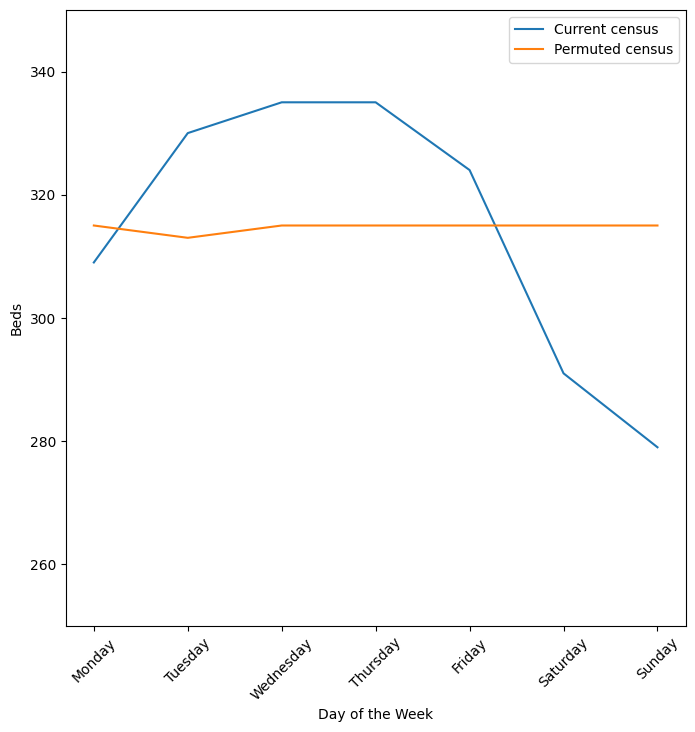

In [103]:
week = 4
weekn = df['Week Number'] == week
weekn
df_weekn = df[weekn]
df_weekn

weekday_daycount = []
for d in range(1, 8):
    day_count = df_weekn[df_weekn['Weekday'] == d]['Beds'].sum()
    weekday_daycount.append(day_count)

weekday_daycount

weekn_re = df_rearrange['Week Number'] == week
df_weekn_re = df_rearrange[weekn_re]

weekday_daycount_re = []
for d in range(1, 8):
    day_count = df_weekn_re[df_weekn_re['Weekday'] == d]['Beds'].sum()
    weekday_daycount_re.append(day_count)



# Define labels for better readability
day_labels = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Count occurrences of each day
day_counts = weekday_daycount
day_counts_re = weekday_daycount_re

# Plot using Matplotlib
plt.figure(figsize=(8, 8))
plt.plot(range(7), day_counts, label='Current census')
plt.plot(range(7), day_counts_re, label='Permuted census')

# Set labels
plt.xticks(ticks=range(7), labels=day_labels, rotation=45)
plt.xlabel("Day of the Week")
plt.ylabel("Beds")
plt.ylim(250, 350)
plt.legend()

# Show plot
plt.show()

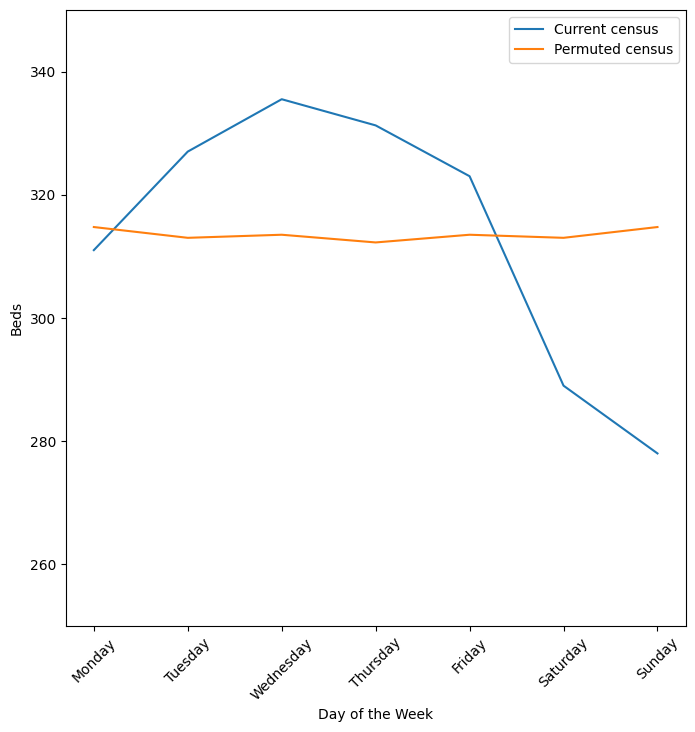

In [110]:
# colculate daycount for each weekn
weekday_daycount_mat = np.zeros((4,7))
weekday_daycount_re_mat = np.zeros((4,7))

for week in range(1,5):
    weekn = df['Week Number'] == week
    df_weekn = df[weekn]
    
    weekday_daycount = []
    for d in range(1, 8):
        day_count = df_weekn[df_weekn['Weekday'] == d]['Beds'].sum()
        weekday_daycount.append(day_count)
    
    weekday_daycount_mat[week-1,:] = weekday_daycount
    
    weekn_re = df_rearrange['Week Number'] == week
    df_weekn_re = df_rearrange[weekn_re]
    
    weekday_daycount_re = []
    for d in range(1, 8):
        day_count = df_weekn_re[df_weekn_re['Weekday'] == d]['Beds'].sum()
        weekday_daycount_re.append(day_count)

    weekday_daycount_re_mat[week-1,:] = weekday_daycount_re

weekday_daycount_avg = np.zeros(7)
weekday_daycount_re_avg = np.zeros(7)

for weekday in range(7):
    weekday_daycount_avg[weekday] = weekday_daycount_mat[:,weekday].mean()
    weekday_daycount_re_avg[weekday] = weekday_daycount_re_mat[:,weekday].mean()
    

# Define labels for better readability
day_labels = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Count occurrences of each day
day_counts = weekday_daycount_avg
day_counts_re = weekday_daycount_re_avg

# Plot using Matplotlib
plt.figure(figsize=(8, 8))
plt.plot(range(7), day_counts, label='Current census')
plt.plot(range(7), day_counts_re, label='Permuted census')

# Set labels
plt.xticks(ticks=range(7), labels=day_labels, rotation=45)
plt.xlabel("Day of the Week")
plt.ylabel("Beds")
plt.ylim(250, 350)
plt.legend()

# Show plot
plt.show()

In [109]:
print(weekday_daycount_avg)
print(weekday_daycount_re_avg)

[311.   327.   335.5  331.25 323.   289.   278.  ]
[314.75 313.   313.5  312.25 313.5  313.   314.75]


In [105]:
a = np.zeros((4,7))
a

array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]])

In [1]:
my_list = [1, 2, 3, 4, 5]
my_list = [my_list[-1]] + my_list[:-1]
print(my_list)


[5, 1, 2, 3, 4]
